In [1]:
from typing import Dict, List, Tuple
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from datetime import datetime
from utils.engine import train_func, test_func
from utils.engine import set_seed

In [2]:
from utils.data_load import load_data

train_dataloader, test_dataloader = load_data("output/", 2)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
def train_func_profiler(model: nn.Module, data: DataLoader, loss_fn:nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device
               , log_dir: str) -> Tuple[float, float]:
    """
    Trains a model for a single epoch

    Args
    ----
        model: A Pytorch model
        data: a DataLoader object with the train data
        loss_fn: loss function to minimized
        optimizer: A Pytorch optimizer
        device: A target device to perform the operations ("cuda" or "cpu")

    Returns
    ------
        A tuple with the loss and accuracy of the training epoch like
        (train_loss, train_acc)
    """
    def trace_handler(prof):
        print(prof.key_averages().table(sort_by="self_cuda_time_total", row_limit=-1))

    model.train()
    train_loss, train_acc = 0, 0
    with torch.profiler.profile(
        schedule=torch.profiler.schedule(
            wait=1,
            warmup=1,
            active=1,
            repeat=1),
        #on_trace_ready=trace_handler,
        on_trace_ready=torch.profiler.tensorboard_trace_handler("./log"),
        with_stack=True
    ) as profiler:
        for _ , (x, y) in enumerate(data):
            x, y = x.to(device), y.to(device)
            y_logit = model(x)
            loss = loss_fn(y_logit, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            profiler.step()
            y_pred = torch.softmax(y_logit, 1).argmax(1)
            train_acc += (y_pred == y).sum().item() / len (y_pred)
            #We can use another function if we want
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)
    return train_loss, train_acc                            

In [11]:
def train(model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
        optimizer: torch.optim.Optimizer, device: torch.device, epochs: int
        , writer: SummaryWriter) -> Dict[str, List]:
    """
    Trains and test a Pytorch model

    Args:
    -----
        model: A Pytorch model
        train_data: a DataLoader object with the train data
        test_data: a DataLoader object with the train data
        loss_fn: loss function to minimized
        optimizer: A Pytorch optimizer
        device: A target device to perform the operations ("cuda" or "cpu")
        epochs: A integre with the number of epochs that the model will be train
    Returns:
    --------
        A dictionary with the train and test loss and accuracy for every epoch
        in the form of 
        {"train_loss": [...],
        "train_acc": [...],
        "test_loss": [...],
        "test_acc": [...]}
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_func(
            model,train_data,loss_fn,optimizer, device)
        test_loss, test_acc = test_func(
            model, test_data, loss_fn, device)
        print(
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_acc :{test_acc: .4f} "
        )
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ##Add of the writer
        if writer:
            writer.add_scalars(main_tag="Loss", 
            tag_scalar_dict={"train_loss": train_loss, "tests_loss": test_loss},
            global_step=epoch
            )

            writer.add_scalars(main_tag="Accuracy", 
            tag_scalar_dict={"train_acc": train_acc, "tests_acc": test_acc},
            global_step=epoch
            )

            writer.close()
    return results

In [15]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv3d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv3d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.LayerNorm((836352,), elementwise_affine=False, eps=1e-5),
            nn.Linear(in_features= 836352,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [17]:
def create_write(name: str, model: str, extra: str=None) -> SummaryWriter():
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")
    if extra:
        log_dir = os.path.join("runs", timestamp, name, model, extra)
    else:
        log_dir = os.path.join("runs", timestamp, name, model)
    print(f"[INFO] create summary writer, saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [23]:
num_epochs = [2, 5, 10]
optimizers = ["Adam", "SGD", "Adamw"]

In [18]:
def select_optimizer(model: nn.Module, optimizer: str):
    if optimizer == "Adam":
        return torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer == "SGD": 
        return torch.optim.SGD(model.parameters(), lr=0.001)
    elif optimizer == "Adamw":
        return torch.optim.AdamW(model.parameters(), lr=0.001)

In [24]:
set_seed()

experiment_number = 0
model_num = 0
loss_fn = nn.CrossEntropyLoss().to(device)
timestamp = datetime.now().strftime("%Y-%m-%d")

for epochs in num_epochs:
    for optimizer_name in optimizers:
        experiment_number += 1
        model_name = "TinyVGG"
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] model: {model_name}")
        print(f"[INFO] Optimizer: {optimizer_name}")
        print(f"[INFO] Epochs: {epochs}")
        model = TinyVGG(input_shape=1, hidden_units=64, output_shape=2).to(device)
        writer = create_write(name=optimizer_name, 
        model=model_name, extra=str(epochs))
        #log_dir = os.path.join("log", timestamp + optimizer + name + str(epochs))
        optimizer = select_optimizer(model, optimizer_name)
        results = train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device,
        epochs, writer)
        print("-" * 50 + "\n")

[INFO] Experiment number: 1
[INFO] model: TinyVGG
[INFO] Optimizer: Adam
[INFO] Epochs: 2
[INFO] create summary writer, saving to: runs/2024-11-21/Adam/TinyVGG/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.5387 |train_acc : 0.6667 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] model: TinyVGG
[INFO] Optimizer: SGD
[INFO] Epochs: 2
[INFO] create summary writer, saving to: runs/2024-11-21/SGD/TinyVGG/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.4216 |train_acc : 0.6667 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] model: TinyVGG
[INFO] Optimizer: Adamw
[INFO] Epochs: 2
[INFO] create summary writer, saving to: runs/2024-11-21/Adamw/TinyVGG/2


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.4064 |train_acc : 0.6667 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] model: TinyVGG
[INFO] Optimizer: Adam
[INFO] Epochs: 5
[INFO] create summary writer, saving to: runs/2024-11-21/Adam/TinyVGG/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.2911 |train_acc : 0.8333 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 3 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 4 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 5 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] model: TinyVGG
[INFO] Optimizer: SGD
[INFO] Epochs: 5
[INFO] create summary writer, saving to: runs/2024-11-21/SGD/TinyVGG/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.3085 |train_acc : 0.6667 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 3 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 4 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 5 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] model: TinyVGG
[INFO] Optimizer: Adamw
[INFO] Epochs: 5
[INFO] create summary writer, saving to: runs/2024-11-21/Adamw/TinyVGG/5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.2244 |train_acc : 0.8333 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 3 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 4 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 5 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] model: TinyVGG
[INFO] Optimizer: Adam
[INFO] Epochs: 10
[INFO] create summary writer, saving to: runs/2024-11-21/Adam/TinyVGG/10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.2883 |train_acc : 0.6667 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 3 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 4 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 5 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 6 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 7 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 8 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 9 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 10 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] model: TinyVGG
[INFO] 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.1136 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 3 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 4 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 5 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 6 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 7 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 8 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 9 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 10 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------

[INFO] Experiment number: 9
[INFO] model: TinyVGG
[INFO] 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 |train_loss : 0.2061 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 2 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 3 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 4 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 5 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 6 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 7 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 8 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 9 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
Epoch 10 |train_loss : 0.0000 |train_acc : 1.0000 |test_loss : 0.0000 |test_acc : 1.0000 
--------------------------------------------------



In [25]:
torch.cuda.empty_cache()

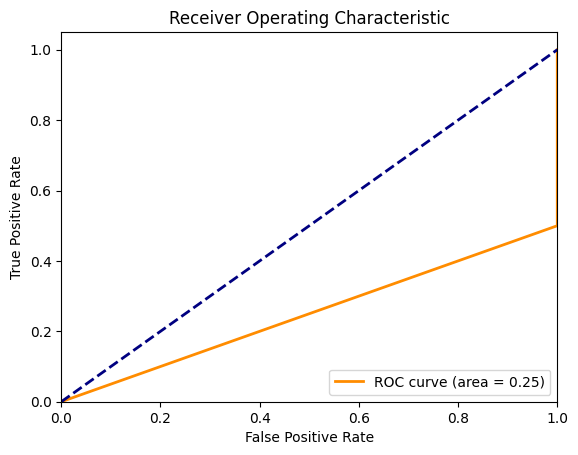

In [2]:
from utils.summary_utils import plot_roc_curve
from sklearn.metrics import roc_curve, auc

train_labels, train_preds = [0, 1, 0, 1], [1, 0, 1, 1]

fprr, tprr, _ = roc_curve(train_labels, train_preds)
roc_auc = auc(fprr, tprr)
roc_fig = plot_roc_curve(fprr, tprr, roc_auc)

roc_fig
